In [1]:
# !git clone git@github.com:maltetoelle/midl.git
# !mv midl/* ./

In [2]:
import os
from typing import Dict, List, Tuple
import json
from datetime import datetime
import warnings
warnings.simplefilter("ignore")
import numpy as np
import fire

import torch
import torch.nn as nn
import torch.multiprocessing as mp

import sklearn.gaussian_process as gp

from bayesian_optimization import BayesianOptimization

from utils.bo_utils import BatchedDIPProblem
from super_resolution import super_resolution
from denoising import denoising
from inpainting import inpainting

In [7]:
exp_name = "bo_inp"
trials = 10
num_iter_eval_fn = 10
batch_size = 3
num_iter_gp = 1000
n_init = 4
criterion = 'nll'
metric = "psnr_gt_sm"
img_name = "skin_lesion0"
task = 'inpainting'
config = "./configs/bo_prior_sigma"
log_dir = "../bo_exps"
trials_log_dir = None
gpus = [0]
seed = 11

In [8]:
torch.manual_seed(seed)
np.random.seed(seed)

with open(config + ".json") as f:
    config = json.load(f)

if log_dir is not None:
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    log_dir = f"{log_dir}/{exp_name}"
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)

# TODO: make that also False when None for path_log_dir in fns
save_trials = False if trials_log_dir is None else True
batch_size = len(gpus) if batch_size is None else batch_size

In [9]:
params = {p["name"]: p["bounds"] for p in config["parameter"]}
lengthscale_prior = config["lengthscale_prior"] if "lengthscale_prior" in list(config.keys()) else dict(concentration=0.3, rate=1.)
lengthscale_constraint = config["lengthscale_constraint"] if "lengthscale_constraint" in list(config.keys()) else 0.05

mean_prior = config["mean_prior"] if "mean_prior" in list(config.keys()) else dict(loc=12., scale=2.)
noise_prior = config["noise_prior"] if "noise_prior" in list(config.keys()) else dict(concentration=1e-2, rate=100.)


initial_params_vals = config["initial_parameter"] if "initial_parameter" in config.keys() else None

acq_kwargs = {"xi": 0.1}

In [10]:
batched_dip_prob = BatchedDIPProblem(
    path_log_dir=trials_log_dir, gpus=gpus, task=task, config=config,
    num_iter_eval_fn=num_iter_eval_fn, save_trials=save_trials,
    img_name=img_name, metric=metric, seed=None
)

bayesian_optimization = BayesianOptimization(
    params=params,
    initial_params_vals=initial_params_vals,
    n_init=n_init,
    obj_fn=batched_dip_prob,
    acq_fn='expected_improvement',
    acq_kwargs=acq_kwargs
)

Starting process 1/4...
Starting process 2/4...
Starting process 3/4...
Starting process 4/4...
Waiting for processes to finish


Training GP...
loss: 10.075 | lengthscale: 0.050 | noise: 0.00010: 100%|██████████| 1000/1000 [00:12<00:00, 83.09it/s]
Starting process 1/3...
Starting process 2/3...
Starting process 3/3...
Waiting for processes to finish


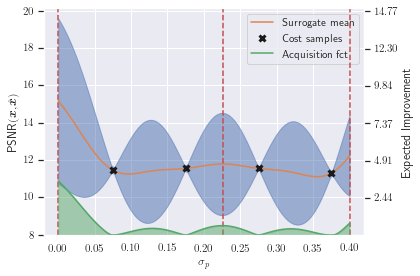

Training GP...
loss: nan | lengthscale: nan | noise: nan:   0%|          | 1/1000 [00:00<00:22, 44.94it/s]


NanError: cholesky_cpu: 49 of 49 elements of the torch.Size([7, 7]) tensor are NaN.

In [11]:
best_params = bayesian_optimization.optimize(
    trials=trials, plot=True, gpu=gpus[0], path=log_dir,
    lengthscale_prior=lengthscale_prior, mean_prior=mean_prior,
    noise_prior=noise_prior, lengthscale_constraint=lengthscale_constraint,
    num_iter_gp=num_iter_gp, batch_size=batch_size
)

print(best_params)